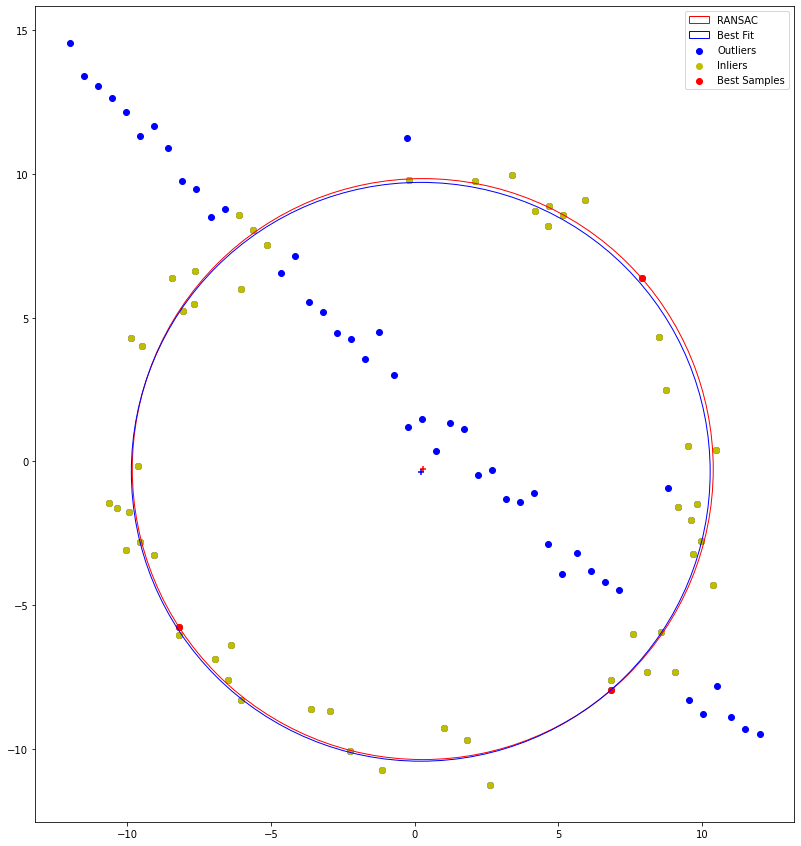

In [1]:
import numpy as np
from scipy.optimize import minimize
from scipy import linalg
import matplotlib.pyplot as plt
np.random.seed(4)
N = 100
half_n = N//2
r = 10
s = r/16
t = np.random.uniform(0, 2*np.pi, half_n)
n = s*np.random.randn(half_n)
x, y = (r + n)*np.cos(t), (r + n)*np.sin(t)
X_circ = np.hstack((x.reshape(half_n, 1), y.reshape(half_n, 1)))
m, b = -1, 2
x = np.linspace(-12, 12, half_n)
y = m*x + b + s*np.random.randn(half_n)
X_line = np.hstack((x.reshape(half_n, 1), y.reshape(half_n, 1)))
X = np.vstack((X_circ, X_line))

threshold = 1.96*s
n = X.shape[0]
best_est = None
best_sample = None
S_in = []
p = 0.99
i = 0
e = 0.5
N = np.log(1 - p) / np.log(1 - e**(n/10))
while N > i:
    random_index = np.random.randint(n, size=3)
    pt1, pt2, pt3 = X[random_index]

    A = np.array([[pt2[0] - pt1[0], pt2[1] - pt1[1]], [pt3[0] - pt2[0], pt3[1] - pt2[1]]]) 
    B = np.array([[pt2[0]**2 - pt1[0]**2 + pt2[1]**2 - pt1[1]**2], [pt3[0]**2 - pt2[0]**2 + pt3[1]**2 - pt2[1]**2]])		
    inv_A = np.linalg.pinv(A)

    a, b = np.dot(inv_A, B) / 2
    a, b = a[0], b[0]
    r = np.sqrt((a - pt1[0])**2 + (b - pt1[1])**2)

    S_tst = []
    for x, y in X:
        dis = np.sqrt((x - a)**2 + (y - b)**2)
        if (np.abs(dis - r) < threshold):
            S_tst.append([x,y])
    
    if (len(S_tst) > len(S_in)):
        best_est = (a, b, r)
        best_sample = random_index
        S_in = S_tst
    i+=1

a, b, r = best_est[0], best_est[1], best_est[2]
S_in = np.array(S_in)
P = np.concatenate((S_in, np.ones((S_in.shape[0], 1))), axis=1)
Q = S_in[:,[0]]**2 + S_in[:, [1]]**2
B = np.linalg.pinv(P.T @ P) @ P.T @ Q
a0, b0, c = B.flatten()
r0 = np.sqrt(a0**2 + b0**2 + c)

fig, ax = plt.subplots(figsize=(15, 15))
ax.scatter(X[:, 0], X[:, 1], c='blue', marker='o', label='Outliers')
ax.scatter(S_in[:, 0], S_in[:, 1], c='y', marker='o', label='Inliers')
ax.scatter(X[best_sample][:, 0], X[best_sample][:, 1], c='r', marker='o', label='Best Samples')
ax.scatter(a, b, c='r', marker='+')
ax.scatter(a0, b0, c='b', marker='+')
circle_best_sample = plt.Circle((a, b), radius=r, color='r', fc='y', fill=False, label='RANSAC')
circle_best_fit = plt.Circle((a0, b0), radius=r0, color='b', fc='y', fill=False, label='Best Fit')
plt.gca().add_patch(circle_best_sample)
plt.gca().add_patch(circle_best_fit)
ax.legend()
ax.axis('scaled')
plt.savefig('Report/images/ransac.png')
plt.show()

In [86]:
import cv2 as cv
Y = np.empty((0,2))
def click_event(event, x, y, flags, params):
    global Y
    if event == cv.EVENT_LBUTTONDOWN and len(Y) < 4:
        Y = np.vstack((Y, [x, y]))
        font = cv.FONT_HERSHEY_SIMPLEX
        cv.putText(img, str(x) + ',' +
                    str(y), (x,y), font,
                    1, (255, 0, 0), 2)
        cv.imshow('image', img)
        
img = cv.imread('001.jpg')
img_copy = img.copy()
cv.imshow('image', img)
cv.setMouseCallback('image', click_event)
cv.waitKey(0)
cv.destroyAllWindows()

uk_flag = cv.imread('uk_flag.png')
shape = uk_flag.shape
X = np.array([[0, 0], [shape[1]-1, 0], [0, shape[0]-1], [shape[1]-1, shape[0]-1]])
A = np.empty((8, 8))
for i in range(4):
    A[2*i] = [X[i][0], X[i][1], 1, 0, 0, 0, -Y[i][0]*X[i][0], -Y[i][0]*X[i][1]]
    A[2*i+1] = [0, 0, 0, X[i][0], X[i][1], 1, -Y[i][1]*X[i][0], -Y[i][1]*X[i][1]]
b = Y.reshape((8,1))

h = np.linalg.inv(A) @ b
H = np.vstack((h,[1]))
H = H.reshape((3, 3))

uk_transformed = cv.warpPerspective(uk_flag, H, (img.shape[1], img.shape[0]))
blend_img = cv.addWeighted(img_copy, 0.7, uk_transformed, 0.3, 0)
cv.imshow('image', blend_img)
cv.waitKey(0)
cv.destroyAllWindows()



In [65]:
d = np.array([1919,959 ,1]).reshape((3,1))
a = H @ d
a/a[-1]

array([[1.023e+03],
       [7.670e+02],
       [1.000e+00]])